# Exercise 6

In [1]:
# Basic
import sys
import time
import random
import pickle
from functools import reduce
from tqdm import tqdm

# Data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# DL
from tensorflow.keras.datasets import mnist

c:\Users\OmriG\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1. Data

In [2]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()

# Flatten pixel images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Normalize pixel values
X_train = X_train / 255
X_test = X_test / 255

(X_train_flat.shape, y_train.shape), (X_test_flat.shape, y_test.shape)

(((60000, 784), (60000,)), ((10000, 784), (10000,)))

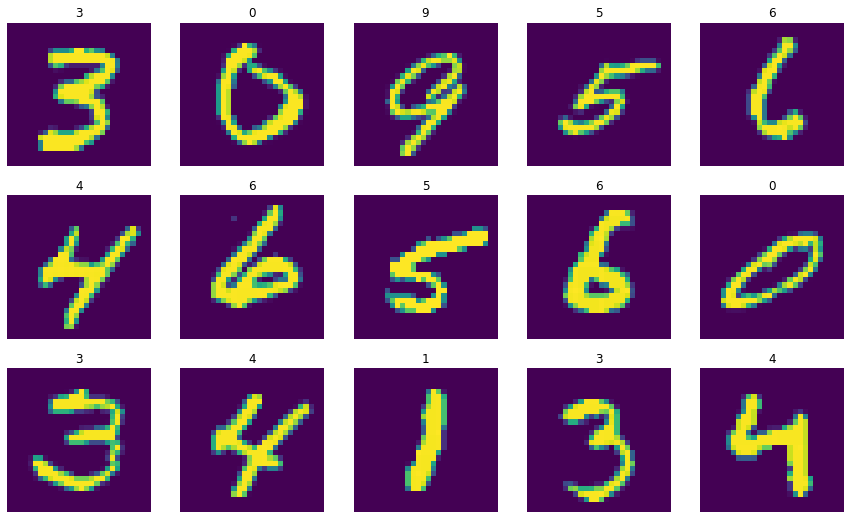

In [3]:
# Plot dimensions
ROWS, COLS = 3, 5
SCALE = 3

# Sampled images
pairs = list(zip(X_train, y_train))
samples = random.sample(pairs, ROWS * COLS)

# Plotting
fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS * SCALE, ROWS * SCALE))
for i, (img, digit) in enumerate(samples):
    row, col = i // COLS, i % COLS
    ax[row, col].imshow(img)
    ax[row, col].set_title(digit)
    ax[row, col].axis('off')

## 2. Model

In [4]:
def softmax(x):
    exp = np.exp(x)
    return exp / np.sum(exp, axis=-1, keepdims=True)

In [5]:
class Activation:
    def func(self, x):
        assert False
        
    def grad(self, x):
        assert False
        
class ReLU(Activation):
    def func(self, x):
        return np.maximum(x, 0)

    def grad(self, x):
        return np.where(x > 0, 1, 0)

class Sigmoid(Activation):
    def func(self, x):
        return 1 / (1 + np.exp(-x))

    def grad(self, x):
        sig = sigmoid(x)
        return sig * (1 - sig)
    
class Tanh(Activation):
    def func(self, x):
        exp = np.exp(x)
        return (exp + (1 / exp)) / (exp - (1 / exp))
    
    def grad(self, x):
        return 1 - self.func(x) ** 2

In [6]:
class Loss:
    def __call__(self, y_true, y_pred):
        assert False
        
class CrossEntropy(Loss):
    def __call__(self, y_true, probabilities):
        return -np.log(probabilities[np.arange(y_true.size), y_true]).sum() / y_true.size

In [7]:
class Optimizer:
    def __init__(self, weights, gradients):
        self.weights = weights
        self.gradients = gradients
        
    def step(gradients):
        assert False

class Adam(Optimizer):
    def __init__(self, weights, gradients, lr=3e-4, beta1=0.9, beta2=0.999):
        super().__init__(weights, gradients)
        
        self.t = 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.mt = 0
        self.vt = 0
        self.lr = lr
        
    def step(self):
        self.t += 1
        
        # Update weights
        for layer, grad in enumerate(self.gradients):
            
            new_mt = self.beta1 * self.mt + (1 - self.beta1) * grad
            new_vt = self.beta2 * self.vt + (1 - self.beta2) * (grad**2)
            
            new_mt = new_mt / (1 - self.beta1 ** self.t)
            new_vt = new_vt / (1 - self.beta2 ** self.t)
            
            self.weights[layer] -= self.lr * new_mt / (np.sqrt(new_vt) + 1e-8)

In [8]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, activation_type, loss_type, optimizer_type, lr=3e-4, max_iter=1000, validation_size=0.2, shuffle=True):
        self.max_iter = max_iter
        self.validation_size = validation_size
        self.shuffle = shuffle
        
        self.layer_sizes = [input_size, *hidden_sizes, output_size]
        self.weights = [
            np.random.uniform(0, 1, size=(size_from, size_to)) / (size_from / 2)
            for size_from, size_to in zip(self.layer_sizes[:-1], self.layer_sizes[1:])
        ]
        self.gradients = [np.zeros_like(w) for w in self.weights]
        
        self.activation = activation_type()
        self.loss_fn = loss_type()
        self.optimizer = optimizer_type(self.weights, self.gradients, lr)
        
        self.train_losses = []
        self.val_losses = []

    def forward(self, X):
        
        # Inputs for each layer (hidden & output)
        self.layer_inputs = [np.zeros((X.shape[0], size)) for size in self.layer_sizes[:-1]]
        self.activation_inputs = [np.zeros((X.shape[0], size)) for size in self.layer_sizes[1:]]
        
        # First layer inputs
        self.layer_inputs[0] = X
        
        # Calculate intermediate values
        for layer, weight in enumerate(self.weights[:-1]):
            
            # Linear layer
            self.activation_inputs[layer] = self.layer_inputs[layer] @ weight
            
            # Activation
            self.layer_inputs[layer + 1] = self.activation.func(self.activation_inputs[layer])
            
        # Last linear layer
        self.activation_inputs[-1] = self.layer_inputs[-1] @ self.weights[-1]
        
        # Logits
        self.output = softmax(self.activation_inputs[-1])
    
    def backward(self, y):
        
        # Zero gradients
        for grad in self.gradients:
            grad.fill(0)
        
        # Gradient of loss w.r.t to softmax input
        one_hot_labels = np.zeros_like(self.output)
        one_hot_labels[np.arange(y.size), y] = 1
        delta = self.output - one_hot_labels
        
        # Iterate over layers
        for layer in range(len(self.gradients) - 1, 0, -1):
            
            # Gradient of loss w.r.t layer weights
            self.gradients[layer] = self.layer_inputs[layer].T @ delta
            
            # Gradient of loss w.r.t to previous layer's input
            delta = self.activation.grad(self.activation_inputs[layer - 1]) * (delta @ self.weights[layer].T)

        # Last gradient of loss w.r.t first layer's weights
        self.gradients[0] = self.layer_inputs[0].T @ delta

    def single_iter(self, X, y, train=True):
        if not train:
            self.output = self.predict_proba(X)
            
        else:
            self.forward(X)
            self.backward(y)
            self.optimizer.step()
            
        return self.loss_fn(y, self.output)
        
    def fit(self, X, y):
        self.train_rows, self.val_rows = train_test_split(np.arange(X_train.shape[0]), test_size=self.validation_size, shuffle=self.shuffle, random_state=42)
        
        pbar = tqdm(total=self.max_iter)
        time.sleep(1)
            
        # Iterate over data
        for _ in range(self.max_iter):
            self.train_losses.append(self.single_iter(X[self.train_rows, :], y[self.train_rows]))
            self.val_losses.append(self.single_iter(X[self.val_rows, :], y[self.val_rows], train=False))
            
            pbar.set_description(f'Train Loss ({self.train_losses[-1]:.3f}), Validation Loss ({self.val_losses[-1]:.3f})')
            pbar.update()
        
        return self

    def predict_proba(self, X):
        return softmax(reduce(lambda x, w: self.activation.func(x @ w), [X, *self.weights[:-1]]) @ self.weights[-1])

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)    

    def score(self, X, y):
        return (self.predict(X) == y).sum() / len(y)
    
    def __repr__(self):
        return f'NN_{len(self.train_rows)}vs{len(self.val_rows)}_[{"-".join(map(str, self.layer_sizes))}]_{type(self.activation).__name__}_{type(self.loss_fn).__name__}_{type(self.optimizer).__name__}'

## 3. Training

In [10]:
def save_model(model, model_path):
    with open(model_path, 'wb') as f:
        pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_model(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

In [9]:
nn_clf = NeuralNetwork(input_size=X_train_flat.shape[1], 
                       hidden_sizes=[256, 256],
                       output_size=np.unique(y_train).size,
                       activation_type=ReLU,
                       loss_type=CrossEntropy,
                       optimizer_type=Adam)
nn_clf.fit(X_train_flat, y_train)

nn_clf_path = f'models/{nn_clf}.pkl'
save_model(nn_clf, nn_clf_path)

Train Loss (0.097), Validation Loss (0.344): 100%|██████████| 1000/1000 [33:17<00:00,  2.00s/it]


NameError: name 'save_model' is not defined

In [14]:
def plot_learning_curves(nn):
    num_iters = len(nn.train_losses)
    iters = np.arange(1, num_iters + 1)

    # Plot Train & Validation Losses
    plt.figure(figsize=(15,15))
    plt.plot(iters, nn.train_losses, label='Training Loss')
    plt.plot(iters, nn.val_losses, label='Validation Loss')
    plt.title(nn)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()

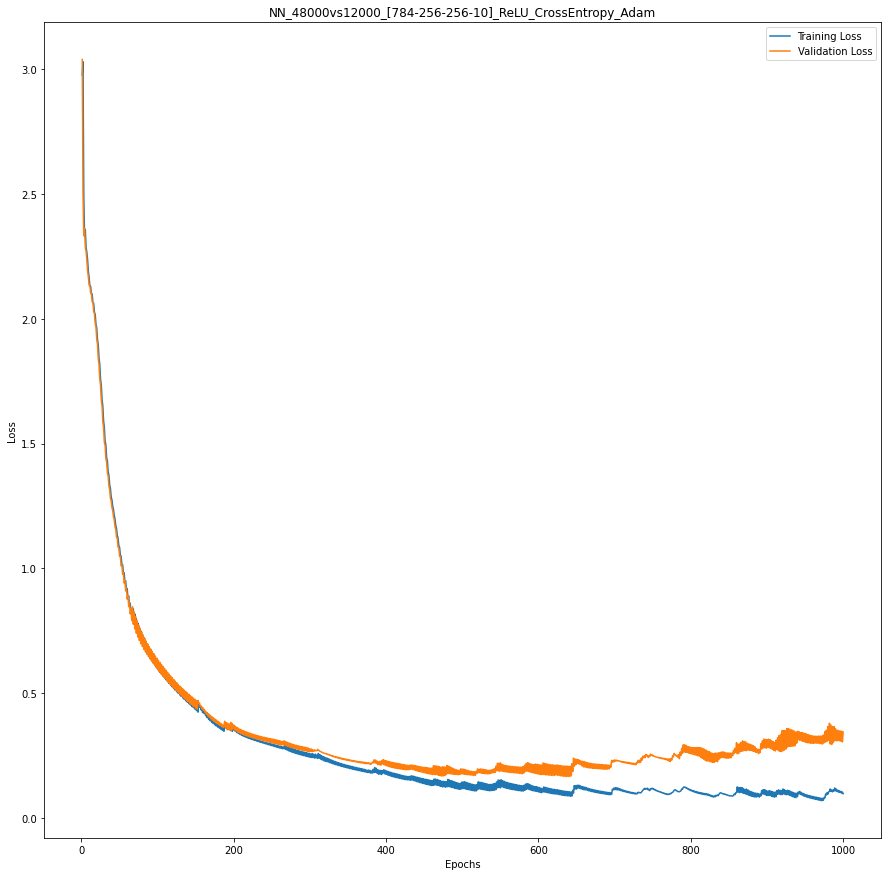

In [15]:
nn_clf = load_model(nn_clf_path)

plot_learning_curves(load_model(nn_clf_path))

## 4. Evaluation

In [23]:
def plot_confusion_matrix(clf, X, y, tag):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y_true=y, y_pred=y_pred)
    
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=cm)
    plt.ylabel("Ground Truth")
    plt.xlabel("Predictions")
    plt.title(f'{clf}, {tag} score: {clf.score(X, y):.3f}')
    plt.show()

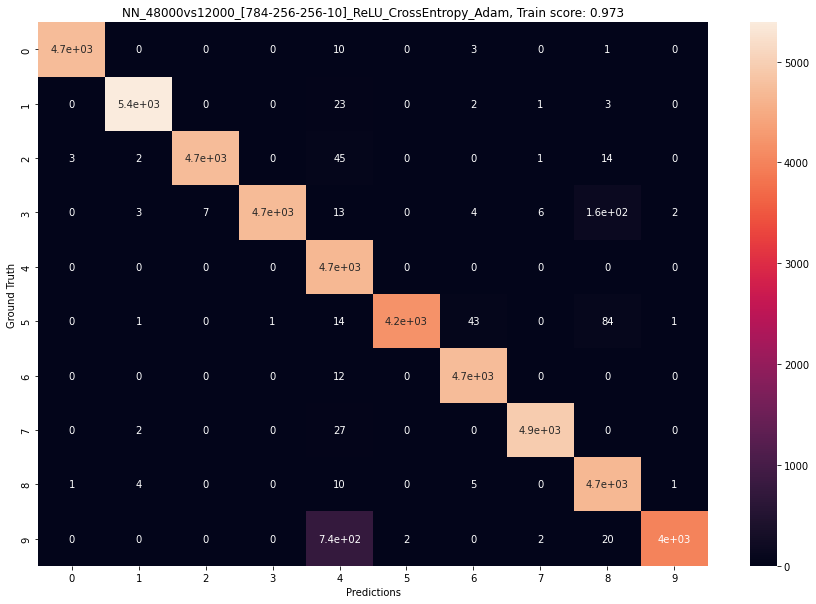

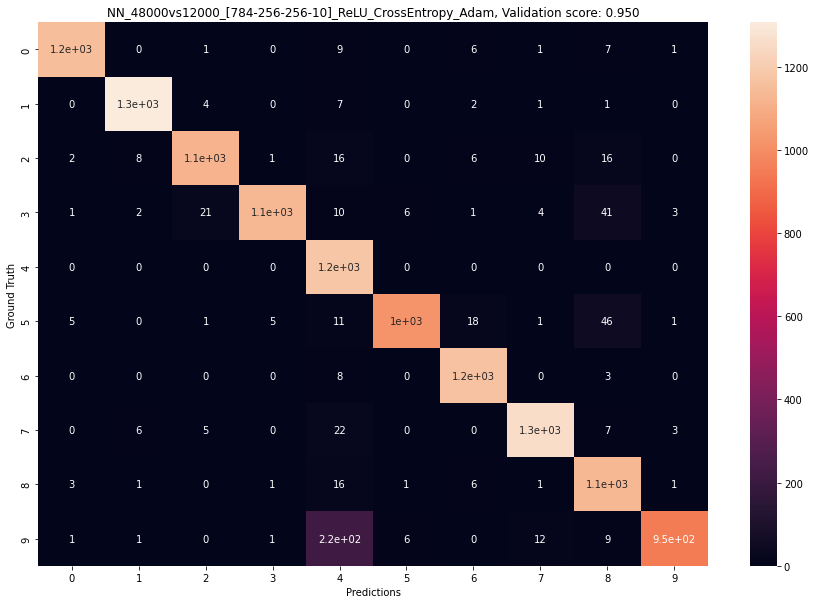

In [24]:
nn_clf = load_model(nn_clf_path)

plot_confusion_matrix(nn_clf, X_train_flat[nn_clf.train_rows, :], y_train[nn_clf.train_rows], "Train")
plot_confusion_matrix(nn_clf, X_train_flat[nn_clf.val_rows, :], y_train[nn_clf.val_rows], "Validation")

## 5. Experiments

In [ ]:
# TODO experiments